In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from glob import glob
from keras.optimizers import Adam
from PIL import Image
from utils import *

Using TensorFlow backend.


In [2]:
NOISE_SHAPE = (1, 1, 100)
IMAGE_SIZE = 64
ADAM_BETA = 0.5
BATCH_SIZE = 64
LABEL_NOISE = 0.1

In [3]:
disc_opt = Adam(lr=0.0002, beta_1=ADAM_BETA)
gen_opt = Adam(lr=0.0001, beta_1=ADAM_BETA)

# BUILD GENERATOR
gen = build_generator(NOISE_SHAPE)
gen.compile(optimizer=gen_opt, loss='binary_crossentropy')

# BUILD DISCRIMINATOR
input_shape = (IMAGE_SIZE,IMAGE_SIZE,4)
disc = build_discriminator(input_shape)
disc.compile(optimizer=disc_opt, loss='binary_crossentropy')

# BUILD GAN(GENERATOR+DISCRIMINATOR)
noise = Input(shape=NOISE_SHAPE)
gened = gen(noise)
result = disc(gened)
gan = models.Model(inputs=noise, outputs=result)
gan.compile(optimizer=gen_opt, loss='binary_crossentropy')

# Training

In [4]:
# path to the folder with input images
INPUT_DATA_DIR = "PATH_TO_POKEMONS"

# convert all images from INPUT_DATA_DIR to array with shape [819,64,64,4]
input_images = np.asarray([
    np.asarray(Image.open(file).resize((IMAGE_SIZE, IMAGE_SIZE)))
    for file in glob(INPUT_DATA_DIR + '*')
])
input_images = normalize(input_images)

for batch in range(2001):
    print('BATCH:{}'.format(batch))
    # fake labels for discriminator in range [0,0.1]
    fake_labels = LABEL_NOISE * np.random.ranf(BATCH_SIZE)
    # real labels for discriminator in range [0.9,1]
    real_labels = 1 - LABEL_NOISE * np.random.ranf(BATCH_SIZE)

    
    fakes, noises = sample_fake(gen,BATCH_SIZE,NOISE_SHAPE)
    reals = sample_faces(input_images,BATCH_SIZE)
    
    #add noises to real image
    reals += 0.5 * np.exp(-batch / 100) * np.random.normal(size=reals.shape)

    # train discriminator,without generator
    gen.trainable = False
    d_loss1 = disc.train_on_batch(reals, real_labels)
    d_loss0 = disc.train_on_batch(fakes, fake_labels)
    gen.trainable = True

    # train generator, without discriminator
    disc.trainable = False
    g_loss = gan.train_on_batch(noises, real_labels)
    disc.trainable = True


    # save weights every 500 batches
    if batch % 500 == 0:
        noise = make_noise(BATCH_SIZE,NOISE_SHAPE)
        frame = gen.predict(noise)
        if os.path.exists('./test_images'): 
            grid_image_size = 8
            save_images(
                denormalize(frame), [grid_image_size,grid_image_size],
                './test_images/' + str(batch) + '.png')
        else:
            os.mkdir('./test_images')

        if os.path.exists('./weights'): 
            gen.save_weights('./weights/' + str(batch) + "_gen.hdf5")
            disc.save_weights('./weights/' + str(batch) + "_disc.hdf5")
        else:
            os.mkdir('./weights')

BATCH:0


c:\install\python\python36\lib\site-packages\keras\engine\training.py:478: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


BATCH:1
BATCH:2
BATCH:3
BATCH:4
BATCH:5


KeyboardInterrupt: 

# Check Generator

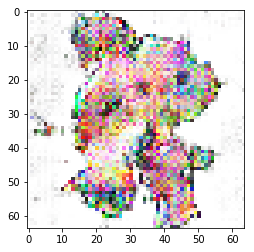

In [5]:
gen.load_weights('./weights/pretrained_generator.hdf5')
noise = make_noise(1,NOISE_SHAPE)
predictions = gen.predict(noise)
predictions = np.squeeze(denormalize(predictions))
imgplot = plt.imshow(predictions)
plt.show()